In [1]:
import numpy as np
import mne

from hdf5storage import loadmat, savemat 
from mne.minimum_norm import make_inverse_operator, apply_inverse, compute_source_psd_epochs, write_inverse_operator

from matplotlib import pyplot as plt


In [2]:
outdict=loadmat('preprocessed_eeg.mat')
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ch_bad', 'ch_dubious', 'ch_labels', 'chanlocs', 'preprocessed_eeg', 'subject_ID'])

In [3]:
preprocessed_eeg=outdict['preprocessed_eeg']*0.000001 # reduce the amplitube to be shown on MNE's plot
sampling_freq=outdict['Fs'][0]


In [4]:
# preprocessed_eeg[1,1000:1100]

In [5]:
# data=raw.get_data()

In [6]:
# data[1,1000:1100]

In [7]:
ch_bad=[] # ch_bad=outdict['ch_bad'][0]-1
ch_dubious=[] # ch_dubious=outdict['ch_dubious'][0]-1

In [8]:

subject_ID=outdict['subject_ID'][0]

n_channels=np.shape(preprocessed_eeg)[0]
ch_info_bads=np.concatenate((ch_bad, ch_dubious), axis=0)
ch_info_bads=np.unique(ch_info_bads)


In [9]:
ch_labels=outdict['ch_labels'].tolist()

In [10]:
ch_labels_names=list()
for i in range(32):
    ch_labels_names.append(ch_labels[i][0][0])

In [11]:
ch_names = [f"E{n}" for n in range(1, 33)]


In [12]:
ch_types = ["eeg"] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("GSN-HydroCel-32",match_case=False,match_alias=False,on_missing='raise', verbose=None)
info["description"] = subject_ID
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: 20220804
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 2000.0 Hz
>


In [13]:
# info.keys()

In [14]:
# info['chs']

In [15]:
# alternative method 
# raw=mne.io.read_raw_fif('./TMSi32chan_loc_small_example.fif') # (this fif file is imported from original Poly5 to EDF to MNE)
# missing dig in the info

In [16]:
# len(info['dig'])

In [17]:
outdict=loadmat('./xyzlabels.mat') # (this xyzlabels.mat has coordinates from original Poly to EDF to MNE)
x=outdict['x']
y=outdict['y']
z=outdict['z']

# this set of xyz does not look right to work as digitaization points for coregistartion, but works for topoplot
for ch in range(3,len(info['dig'])):
    info['dig'][ch]['r'][0]=x[ch-3]
    info['dig'][ch]['r'][1]=y[ch-3]
    info['dig'][ch]['r'][2]=z[ch-3]

In [18]:
# info['dig']

In [19]:
# info['chs'][0] # don't know why it is different from dig

In [20]:
# outdict=loadmat('./xyzlabels.mat') # (this xyzlabels.mat has coordinates from original Poly to EDF to MNE)
# x=outdict['x']
# y=outdict['y']
# z=outdict['z']

for ch in range(32):
    info['chs'][ch]['loc'][0]=x[ch]
    info['chs'][ch]['loc'][1]=y[ch]
    info['chs'][ch]['loc'][2]=z[ch]

In [21]:
# info['dig']

In [22]:
# info['chs'][0]

In [23]:
outdict=loadmat('./xyzlabels.mat') # (this xyzlabels.mat has coordinates from original Poly to EDF to MNE)
Coordinates=np.zeros((32,3))
Coordinates[:,0]=outdict['x']
Coordinates[:,1]=outdict['y']
Coordinates[:,2]=outdict['z']

In [24]:
# Coordinates=outdict['Coordianates']/1000
# for ch in range(3,len(info['dig'])):
#     info['dig'][ch]['r']=Coordinates[ch-3,:]

In [25]:
# mark the bad channels
ch_labels_info_bads=list()
for k in range(len(ch_info_bads)):
    ch_labels_info_bads.append(ch_names[ch_info_bads[k]])

info['bads'] = ch_labels_info_bads

In [26]:
raw = mne.io.RawArray(preprocessed_eeg, info)
raw.set_eeg_reference('average', projection=True)

Creating RawArray with float64 data, n_channels=32, n_times=267074
    Range : 0 ... 267073 =      0.000 ...   133.536 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 32 x 267074 (133.5 s), ~65.3 MB, data loaded>

In [27]:
# raw.plot(show_scrollbars=False, show_scalebars=False)

In [28]:
raw.save("raw.fif",overwrite=True)

Overwriting existing file.
Writing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/raw.fif
Closing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/raw.fif
[done]


In [29]:
# fig = mne.viz.plot_alignment(
#     raw.info)
# mne.viz.set_3d_view(fig)

In [30]:
# # topoplot
# import numpy as np
# x=np.random.rand(32)
# x=list(x*100)
# # x=list(range(1,33,1))
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1)
# mne.viz.plot_topomap(x, \
#     raw.info, vlim=(None, None), axes=ax,\
#         sensors=True, names=ch_labels_names, cmap='seismic')

coregistration

In [31]:
# mne.gui.coregistration()

forward solution

In [32]:
# the raw file containing the channel location + types
raw_fname = './raw.fif'

# The paths to Freesurfer reconstructions
subjects_dir ='../../archive/subjects/'
subject = 'fsaverage' # change it to use freesurfer's bem

# Compute Source Space (surface)
ico = 4 #**************************************************************
spacing='ico'+str(ico) 
src = mne.setup_source_space(subject, spacing=spacing, add_dist='patch',
                             subjects_dir=subjects_dir)
conductivity = (0.3, 0.0075, 0.3)  #  three layers for EEG (MNE default  (0.3 0.006 0.3) )
model = mne.make_bem_model(subject=subject, ico=ico,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
# 5 s


Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/../../archive/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/../../archive/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/../../archive/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan_R/../../archive/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (4

In [33]:
bem = mne.make_bem_solution(model)

trans = './tmsi_trans.fif'
# 1m 10s

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        outer skin  (2562) -> outer skin  (2562) ...
        outer skin  (2562) -> outer skull (2562) ...
        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.


In [34]:
# # view surfaces
# plot_bem_kwargs = dict(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     brain_surfaces="white",
#     orientation="coronal",
#     slices=[50, 100, 150, 200],
# )

# mne.viz.plot_bem(**plot_bem_kwargs)

In [35]:
# # visualing the coregistration 
# info = mne.io.read_info(raw_fname)
# # Here we look at the dense head, which isn't used for BEM computations but
# # is useful for coregistration.
# mne.viz.plot_alignment(
#     info,
#     trans,
#     subject=subject,
#     dig=True,
#     subjects_dir=subjects_dir,
#     surfaces="pial",
# )

In [36]:
# mne.viz.plot_bem(src=src, **plot_bem_kwargs)

In [37]:
# surface = '../../archive/subjects/fsaverage/bem/inner_skull.surf'
# vol_src = mne.setup_volume_source_space(
#     subject, subjects_dir=subjects_dir, surface=surface, add_interpolator=False
# )  # Just for speed!
# print(vol_src)

# mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

In [38]:
# fig = mne.viz.plot_alignment(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     surfaces="white",
#     coord_frame="mri",
#     src=src,
# )
# mne.viz.set_3d_view(
#     fig,
#     azimuth=173.78,
#     elevation=101.75,
#     distance=0.30,
#     focalpoint=(-0.03, -0.01, 0.03),
# )

In [39]:
fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=True)
print(fwd)

# 10s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562>, <surface (rh), n_vertices=163842, n_used=2562>] MRI (surface RAS) coords, subject 'fsaverage', ~30.8 MB>
MRI -> head transform : ./tmsi_trans.fif
Measurement data      : raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999231 -0.035340  0.017012      -2.10 mm
     0.036517  0.996533 -0.074755      12.96 mm
    -0.014311  0.075319  0.997057      -2.61 mm
     0.000000  0.000000  0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 2562 points...
    Found  609/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/1953 points outside using surface Qhull


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/1953 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 6227.1 ms
Checking surface interior status for 2562 points...
    Found  561/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/2001 points outside using surface Qhull


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/2001 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 501.4 ms

Setting up for EEG...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished


Computing EEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Finished.
<Forward | MEG channels: 0 | EEG channels: 32 | Source space: Surface with 5124 vertices | Source orientation: Free>


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.8s finished


In [40]:
# lh = fwd["src"][0]  # Visualize the left hemisphere
# verts = lh["rr"]  # The vertices of the source space
# tris = lh["tris"]  # Groups of three vertices that form triangles
# dip_pos = lh["rr"][lh["vertno"]]  # The position of the dipoles
# dip_ori = lh["nn"][lh["vertno"]]
# dip_len = len(dip_pos)
# dip_times = [0]
# white = (1.0, 1.0, 1.0)  # RGB values for a white color

# actual_amp = np.ones(dip_len)  # misc amp to create Dipole instance
# actual_gof = np.ones(dip_len)  # misc GOF to create Dipole instance
# dipoles = mne.Dipole(dip_times, dip_pos, actual_amp, dip_ori, actual_gof)
# trans = mne.read_trans('tmsi_trans.fif')

# fig = mne.viz.create_3d_figure(size=(600, 400), bgcolor=white)
# coord_frame = "mri"

# # Plot the cortex
# mne.viz.plot_alignment(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     trans=trans,
#     surfaces="white",
#     coord_frame=coord_frame,
#     fig=fig,
# )

# # Mark the position of the dipoles with small red dots
# mne.viz.plot_dipole_locations(
#     dipoles=dipoles,
#     trans=trans,
#     mode="sphere",
#     subject=subject,
#     subjects_dir=subjects_dir,
#     coord_frame=coord_frame,
#     scale=7e-4,
#     fig=fig,
# )

# mne.viz.set_3d_view(figure=fig, azimuth=180, distance=0.25)

In [41]:
# fig = mne.viz.create_3d_figure(size=(600, 400))

# # Plot the cortex
# mne.viz.plot_alignment(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     trans=trans,
#     surfaces="white",
#     coord_frame="head",
#     fig=fig,
# )

# # Show the three dipoles defined at each location in the source space
# mne.viz.plot_alignment(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     trans=trans,
#     fwd=fwd,
#     surfaces="white",
#     coord_frame="head",
#     fig=fig,
# )

# mne.viz.set_3d_view(figure=fig, azimuth=180, distance=0.1)

In [42]:
# fig = mne.viz.create_3d_figure(size=(600, 400))

# # Plot the cortex
# mne.viz.plot_alignment(
#     subject=subject,
#     subjects_dir=subjects_dir,
#     trans=trans,
#     surfaces="white",
#     coord_frame="head",
#     fig=fig,
# )

# # Show the dipoles as arrows pointing along the surface normal
# mne.viz.plot_dipole_locations(
#     dipoles=dipoles,
#     trans=trans,
#     mode="arrow",
#     subject=subject,
#     subjects_dir=subjects_dir,
#     coord_frame="head",
#     scale=7e-4,
#     fig=fig,
# )

# mne.viz.set_3d_view(figure=fig, azimuth=180, distance=0.1)

In [43]:
# src

In [44]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
source_rr=fwd_fixed['source_rr']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 32 sensors x 5124 dipoles


In [45]:
mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)

Overwriting existing file.


/tmp/ipykernel_1640309/1225453021.py:1: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)


    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


/tmp/ipykernel_1640309/1225453021.py:1: RuntimeWarning: This forward solution is based on a forward solution with free orientation. The original forward solution is stored on disk in X/Y/Z RAS coordinates. Any transformation (surface orientation or fixed orientation) will be reverted. To reapply any transformation to the forward operator please apply convert_forward_solution after reading the forward solution with read_forward_solution.
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)


inv

In [46]:
# raw=mne.io.read_raw_fif(raw_fname)

In [47]:
data_cov=mne.compute_raw_covariance(raw)

Using up to 667 segments
Number of samples used : 266800
[done]


In [48]:
# # use the entire data as empty room noise
# noise_cov = mne.compute_raw_covariance(raw)
# noise_cov_mat=noise_cov['data'] # it only included the good chans
# # compute the average of the diagonal
# # construct the scale of the noise cov
# scale=0.05 # 1% 5% 10% 30% 50% *******************************************************************************
# scale_ave=np.sqrt(np.mean(noise_cov_mat.diagonal()))*scale
# sim_cov_mat=np.zeros((np.shape(noise_cov_mat)))
# for i in range(np.shape(sim_cov_mat)[0]):
#        sim_cov_mat[i,i]=scale_ave
# sim_cov=noise_cov.copy()
# sim_cov['data']=sim_cov_mat


In [49]:
# sim_cov = mne.compute_raw_covariance(raw, tmin=10, tmax=20, method="shrunk", method_params='pca', cv=3, rank=None)
# sim_cov = mne.compute_raw_covariance(raw, tmin=10, tmax=10.2, method="auto")
# sim_cov_mat=sim_cov['data']

#The method used for covariance estimation. If ‘empirical’ (default), the sample covariance will be computed. A list can be passed to perform estimates using multiple methods. If ‘auto’ or a list of methods, the best estimator will be determined based on log-likelihood and cross-validation on unseen data as described in 1. Valid methods are ‘empirical’, ‘diagonal_fixed’, ‘shrunk’, ‘oas’, ‘ledoit_wolf’, ‘factor_analysis’, ‘shrinkage’, and ‘pca’ (see Notes). If 'auto', it expands to:
# ['shrunk', 'diagonal_fixed', 'empirical', 'factor_analysis']
# 'factor_analysis' is removed when rank is not ‘full’. The 'auto' mode is not recommended if there are many segments of data, since computation can take a long time.

In [50]:
# noise_cov_mat.diagonal()

In [51]:
# plt.imshow(noise_cov_mat,vmin=-1.5e-10, vmax=1.5e-10, cmap='jet')
# plt.colorbar()
# np.mean(noise_cov_mat.diagonal())

In [52]:
# mne.write_cov('noise_cov.fif', noise_cov, overwrite=True, verbose=None)
# mne.write_cov('sim_cov.fif', sim_cov, overwrite=True, verbose=None)

In [53]:
# nepochs=int(np.floor(np.shape(preprocessed_eeg)[1]/sampling_freq))
# epochs_mat = np.column_stack(
#     (
#         np.arange(0, np.shape(preprocessed_eeg)[1]-sampling_freq, sampling_freq),
#         np.zeros(nepochs, dtype=int),
#         np.array([1]*nepochs),
#     )
# )


In [54]:

# epoch_dict = dict(resting=1)
# epochs = mne.Epochs(raw, epochs_mat, tmin=0, tmax=0.999, event_id=epoch_dict, preload=True, baseline=(None, None))

# evoked = epochs["resting"].average()
# mne.write_evokeds('resting_ave.fif', evoked, on_mismatch='raise', overwrite=True, verbose=None)
# evokeds = mne.read_evokeds('./resting_ave.fif')
# resting = evokeds[0]

In [55]:
# fwd = mne.read_forward_solution('fwd.fif')
fwd_surf=mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


In [56]:
# Compute the source estimate (Fixed dipole orientations)
depth=0.8 # 0.8 1 2 4 ***************************************************************************************
# inverse_operator = make_inverse_operator(resting.info, fwd, sim_cov, depth=depth, fixed=True)
inverse_operator = make_inverse_operator(raw.info, fwd_surf, data_cov, depth=depth, fixed=True)
# save the inverse operator and the inverse matrix
# write_inverse_operator('inv.fif', inverse_operator,overwrite=True)

Computing inverse operator with 32 channels.
    32 out of 32 channels remain after picking
Selected 32 channels
Creating the depth weighting matrix...
    32 EEG channels
    limit = 5125/5124 = 3.100642
    scale = 58980.7 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 7.2e-13 (2.2e-16 eps * 32 dim * 1e+02  max singular value)
    Estimated rank (eeg): 31
    EEG: rank 31 computed from 32 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.12535
    scaling factor to adjust the trace = 3.92676e+19 (nchan = 32 nzero = 1)


linearly constrained minimum variance (LCMV) beamformer

In [57]:
# from mne.beamformer import make_lcmv, apply_lcmv, apply_lcmv_raw

In [58]:
filters = make_lcmv(
    raw.info,
    fwd,
    data_cov,
    reg=0.05,
    noise_cov=None,
    pick_ori="max-power",
    weight_norm="unit-noise-gain",
    rank=None,
)

# # You can save the filter for later use with:
# # filters.save('filters-lcmv.h5')

# # stc = apply_lcmv(evoked, filters)
# stc = apply_lcmv_raw(raw,filters) 
# # 32s

NameError: name 'make_lcmv' is not defined

In [ ]:
# np.shape(stc.data)

(5124, 258122)

In [ ]:
# filters_vec = make_lcmv(
#     evoked.info,
#     fwd,
#     noise_cov,
#     reg=0.05,
#     noise_cov=sim_cov,
#     pick_ori="vector",
#     weight_norm="unit-noise-gain-invariant",
#     rank=None,
# )
# # save a bit of memory
# # src = fwd_fixed["src"]
# # del fwd_fixed
# stc_vec = apply_lcmv(evoked, filters_vec)

In [60]:
%run extract_invmat.ipynb # run this script to load the functions needed to extract inverse matrix

In [61]:
methods = ['MNE','dSPM','sLORETA','eLORETA'] # **********************************************
method = methods[0]  # (could also be dSPM or sLORETA)# **********************************************
# invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd,method=method,lambda2=1.0/9.0)
# invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd_fixed,method=method,lambda2=1.0/9.0)
invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd_surf,method=method,lambda2=1.0/9.0)
np.shape(invmat)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 31 (1 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 32 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  81.7% variance
[done]
Dimension of Inverse Matrix: (5124, 32)


(5124, 32)

Correlation

In [ ]:
# not ch_info_bads

In [62]:
# remove bad channels from the original eeg
if ch_info_bads:
    original_eeg=np.delete(preprocessed_eeg,ch_info_bads,0)
else:
    original_eeg=preprocessed_eeg

/tmp/ipykernel_1640309/1154960953.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if ch_info_bads:


In [63]:
# reconstruct eeg using invmat and leadfield matrix
source_data=np.matmul(invmat,original_eeg)
EEG_recon=np.matmul(leadfield,source_data)
# 11s

In [64]:
original_eeg[10,10000:11100]

array([-5.12443690e-06, -5.20283710e-06, -5.27778966e-06, ...,
       -9.79474514e-06, -9.61365994e-06, -9.42940477e-06])

In [65]:
source_data[10,10000:11100]

array([2.65338410e-11, 2.66944579e-11, 2.68672373e-11, ...,
       4.42612606e-11, 4.24624678e-11, 4.07183734e-11])

In [66]:
EEG_recon[10,10000:11100]

array([ 5.34380262e-07,  4.18944221e-07,  3.00650222e-07, ...,
       -1.11290738e-06, -1.02358267e-06, -9.17202011e-07])

In [67]:
# remove bad channels from the reconstructed eeg
if ch_info_bads:
    EEG_recon=np.delete(EEG_recon,ch_info_bads,0)


/tmp/ipykernel_1640309/2141909429.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if ch_info_bads:


In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon.transpose())
# plt.title('reconstructed EEG - all chan')
# plt.ylim([-2e-5,2e-5])
# # 16 s

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_dubious,:].transpose())
# plt.title('reconstructed EEG - dubious chan')
# plt.ylim([-2e-5,2e-5])

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_bad,:].transpose())
# plt.title('reconstructed EEG - bad chan')
# plt.ylim([-2e-5,2e-5])

In [68]:
# compute correlation
corr = np.corrcoef(EEG_recon, original_eeg, rowvar=True)

In [ ]:
# # examine 
# chan=22 # 12, 30
# plt.subplot(1,2,1)
# plt.plot(np.arange(np.size(original_eeg,1)),original_eeg[chan,:],'r')
# plt.title('original_eeg')
# plt.subplot(1,2,2)
# plt.plot(np.arange(np.size(EEG_recon,1)),EEG_recon[chan,:],'b')
# plt.title('reconstructed eeg')

In [ ]:
# # examine
# chan=31 # 12, 30
# nsamples=2000
# plt.subplot(1,2,1)
# plt.plot(np.arange(nsamples),original_eeg[chan,10000:10000+nsamples],'r')
# plt.title('original_eeg')
# plt.subplot(1,2,2)
# plt.plot(np.arange(nsamples),EEG_recon[chan,10000:10000+nsamples],'b')
# plt.title('reconstructed eeg')

In [ ]:
# corr

In [ ]:
# np.arange(0,np.shape(EEG_recon)[0],1)+194

In [ ]:
# corr=corr[np.arange(0,np.shape(EEG_recon)[0],1)]

In [ ]:
# np.shape(corr)

In [ ]:
# corr=corr[:,np.arange(194,388,1)]

In [ ]:
# plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
# plt.ylabel('reconstructed EEG (194 good channels)')
# plt.xlabel('original EEG (194 good channels)')
# plt.title('correlation')
# plt.colorbar()

In [ ]:
# plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
# plt.colorbar()
# plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth))

In [69]:
corrcoef_diag=np.zeros((np.shape(EEG_recon)[0]))
for i in range(np.shape(EEG_recon)[0]):
    corrcoef_diag[i]=corr[i,np.shape(EEG_recon)[0]+i]


In [70]:
corrcoef_diag

array([0.30356252, 0.33180717, 0.34331464, 0.22231525, 0.37340253,
       0.49814025, 0.14747683, 0.39335886, 0.39478741, 0.40200238,
       0.50246239, 0.41358673, 0.40382301, 0.20906645, 0.26669582,
       0.26134091, 0.31303819, 0.39926352, 0.38909377, 0.28018551,
       0.37908919, 0.33815244, 0.37111227, 0.55076381, 0.04815045,
       0.4759706 , 0.4077665 , 0.41822236, 0.41281512, 0.38749004,
       0.33707765, 0.40392384])

NameError: name 'scale' is not defined

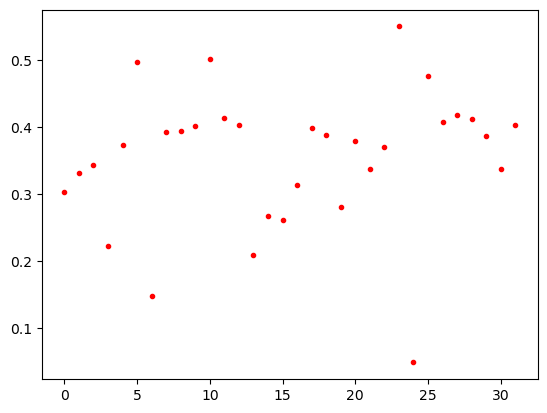

In [71]:
plt.plot(np.arange(0, np.shape(EEG_recon)[0],1) ,corrcoef_diag, 'r.')
plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth)+'\nusing mne.compute_raw_covariance')
plt.xlabel('channels')
plt.ylabel('corrcoef')

In [ ]:
# corrcoef_diag # chan 13 (M1) and chan 31(OZ) have lowest correlation

In [ ]:
# save outputs all in one mat file. 
outdict=dict()
outdict['leadfield']=leadfield # leadfield matrix
outdict['invmat']=invmat #  inverse matrix
outdict['source_rr']=source_rr # the source location AND labels (matlab)
outdict['sim_cov_mat']=sim_cov_mat # noise covariance
outdict['scale']=scale # scale
outdict['depth']=depth # depth
outdict['conductivity']=conductivity # 3 layrs conductivity


outdict['ch_bad']=ch_bad #  inverse matrix
outdict['ch_dubious']=ch_dubious # 
outdict['ch_names']=ch_names #  
outdict['Coordinates']=Coordinates #  
outdict['corrcoef_diag']=corrcoef_diag #  
outdict['subject_ID']=subject_ID #  

savemat(subject_ID+'_scale_'+str(scale)+'_depth_'+str(depth),outdict)

In [ ]:
# outdict=dict()
# outdict['leadfield']=leadfield # leadfield matrix
# outdict['invmat']=invmat #  inverse matrix
# outdict['source_rr']=source_rr # the source location AND labels (matlab)
# outdict['sim_cov_mat']=sim_cov_mat # noise covariance
# # stc_data=stc.data
# # outdict['stc']=stc_data # the source estimate
# outdict['scale']='auto' # scale
# outdict['depth']=depth # depth
# outdict['conductivity']=conductivity # 3 layrs conductivity
# outdict['ch_bad']=ch_bad #  inverse matrix
# outdict['ch_dubious']=ch_dubious # 
# outdict['ch_names']=ch_names #  
# outdict['Coordinates']=Coordinates #  
# outdict['corrcoef_diag']=corrcoef_diag #  
# outdict['subject_ID']=subject_ID #  
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+'auto'+'_depth_'+str(depth),outdict)

In [ ]:
# outdict=dict()
# outdict['leadfield']=leadfield # leadfield matrix
# outdict['invmat']=invmat #  inverse matrix
# outdict['source_rr']=source_rr # the source location AND labels (matlab)
# outdict['sim_cov_mat']=sim_cov_mat # noise covariance
# # stc_data=stc.data
# # outdict['stc']=stc_data # the source estimate
# outdict['scale']=scale # scale
# outdict['depth']=depth # depth
# outdict['conductivity']=conductivity # 3 layrs conductivity
# outdict['ch_bad']=ch_bad #  inverse matrix
# outdict['ch_dubious']=ch_dubious # 
# outdict['ch_names']=ch_names #  
# outdict['Coordinates']=Coordinates #  
# outdict['corrcoef_diag']=corrcoef_diag #  
# outdict['subject_ID']=subject_ID #  
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth),outdict)


In [ ]:
# np.shape(stc.data)

In [ ]:
# # outdict=dict()
# stc_data=stc.data
# stc_data1=stc_data[0:1000,:]
# stc_data2=stc_data[1000:2000,:]
# stc_data3=stc_data[2000:3000,:]
# stc_data4=stc_data[3000:4000,:]
# stc_data5=stc_data[4000::,:]

In [ ]:
# stc.save("stc.fif",overwrite=True, ftype='h5')

In [ ]:
# outdict['stc_data']=stc_data # the source estimate


In [ ]:
# import scipy
# scipy.__version__


In [ ]:
# import sklearn
# sklearn.__version__

In [ ]:
# pip install scipy==1.11.3
# the previous version is 1.9 compatible with sklearn 1.2.0

In [ ]:
# scipy.io.savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data',
#                  outdict,oned_as='column',format='5',do_compression=True)
# # 1 min

In [ ]:
# import pickle as pkl
# filename = subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data'
# fileObject = open(filename, 'wb')
# pkl.dump(stc_data, fileObject)
# fileObject.close()

In [ ]:
# import hdf5storage
# hdf5storage.__version__
# # it was 0.1.18 previously

In [ ]:
# pip install hdf5storage==0.1.19

In [ ]:
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data.mat',
#         outdict,do_compression=True,format='7.3')

In [ ]:
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data1.mat',
#         {"stc_data1": stc_data1},do_compression=True,format='7.3')
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data2.mat',
#         {"stc_data2": stc_data2},do_compression=True,format='7.3')
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data3.mat',
#         {"stc_data3": stc_data3},do_compression=True,format='7.3')
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data4.mat',
#         {"stc_data4": stc_data4},do_compression=True,format='7.3')
# savemat(subject_ID +'_method_' + methods[0]+'_ico_'+str(ico)+'_scale_'+str(scale)+'_depth_'+str(depth)+'_st.data5.mat',
#         {"stc_data5": stc_data5},do_compression=True,format='7.3')